## Socioeconomic Data for RBI using pyNHD

#### pip install required packages

In [1]:
import sys
#!{sys.executable} -m pip install geopandas==0.9.0
!{sys.executable} -m pip install pynhd
#!{sys.executable} -m pip install cenpy
# forked package to include BG
#!{sys.executable} -m pip install git+https://github.com/jbousquin/cenpy.git
#!{sys.executable} -m pip install git+https://github.com/jbousquin/cenpy.git
#!{sys.executable} -m pip install git+https://github.com/walkerke/pygris.git
#!{sys.executable} -m pip install git+https://github.com/jbousquin/pygris.git@multi
#!conda install --yes --prefix {sys.prefix} descartes
!{sys.executable} -m pip install mapclassify==2.4.3

### Retrieve boundary data

#### Hydrology

In [2]:
from pynhd import NLDI, WaterData
import pandas

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
def sub_huc_list(HUC_list, level):
    '''
    Takes a list of HUCs at one level and adds potential digits to get to 
    user specified level
    '''
    expanded_HUC_list = []
    # expand list out, e.g., 1504xxxx
    for HUC in HUC_list:
        current_level = len(str(HUC))
        n = level - current_level
        expanded_HUC = int(HUC)*(10**n)
        #AOI_08 = [x*(10**n) for x in AOI]
        digits = list(range(0,(10**n)))
        if isinstance(HUC, str) and HUC.startswith('0'):
            expanded_HUC_list += ['0' + str(expanded_HUC + digit) for digit in digits]
        else:
            expanded_HUC_list += [expanded_HUC + digit for digit in digits]
    return expanded_HUC_list


def catchment_by_HUC(huc_df):
    '''Retrieve catchment geometry for AOI HUC-8s
    huc_df must have 'geometry' and 'huc8' columns
    '''
    wd_cat = WaterData("catchmentsp")  # Catchments
    aoi_cats = None
    for i, huc in enumerate(huc_df['geometry']):
        huc_id = huc_df.iloc[i]['huc8']
        # TODO: shorten to huc[i]?
        aoi_cat = wd_cat.bygeom(huc_df.geometry[i], predicate="INTERSECTS")
        aoi_cat['huc8'] = huc_id
        if aoi_cats is None:
            aoi_cats = aoi_cat  # First instance
        else:
            aoi_cats = pandas.concat([aoi_cats, aoi_cat], ignore_index=True)
    return aoi_cats.reset_index(drop=True)

In [4]:
# Define AOI as a set of HUC4s
# Ohio River Basin (entire HUC2 05)
#AOI = ['05']  # Special because many and starts with '0'
# Lower Missouri River (HUC4s 1025, 1026, and 1027)
#AOI = [1025, 1026, 1027]
# Texas Gulf Coast (HUC4s 1201, 1202, and 1203)
AOI = [1201, 1202, 1203]
# Gila and Salt Rivers in AZ (HUC4s 1504 and 1506)
#AOI = [1504, 1506]
# SDR
#AOI = ['02080110']

In [5]:
# Fill out the list for HUC-08
AOI_08_all = sub_huc_list(AOI, 8)
len(AOI_08_all)

30000

In [6]:
# Retrieve geometry for AOI HUCs
wbd_08 = WaterData(layer='huc08')
aoi_huc08 = wbd_08.byid(featurename='huc8', featureids=AOI_08_all)
aoi_huc08 = aoi_huc08.reset_index(drop=True)  # gets appended so re-index

The following requested feature IDs were not found in WaterData:
12012159, 12016260, 12035727, 12017956, 12033484, 12016341, 12014877, 12016438, 12039883, 12033667, 12034347, 12020835, 12010196, 12017672, 12039844, 12037089, 12039240, 12012590, 12031058, 12017871, 12028001, 12015775, 12037938, 12025466, 12016085, 12039020, 12013344, 12035523, 12028754, 12034270, 12019072, 12030471, 12020852, 12036989, 12025265, 12014735, 12032664, 12038071, 12023347, 12028888, 12022322, 12017386, 12026420, 12011846, 12017090, 12021088, 12020140, 12026721, 12035829, 12029255, 12023381, 12014918, 12031156, 12024713, 12021812, 12019329, 12020102, 12028611, 12018926, 12037142, 12026544, 12020368, 12025088, 12020772, 12033849, 12025313, 12017287, 12020738, 12019050, 12015867, 12035746, 12033255, 12017597, 12010551, 12022872, 12010686, 12026538, 12037159, 12011631, 12028157, 12039497, 12014909, 12013555, 12035926, 12024660, 12019363, 12026149, 12019511, 12020280, 12019532, 12016183, 12016865, 12038178, 12019

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

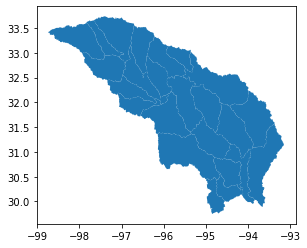

In [7]:
# Map out the AOI quick
aoi_huc08.plot()

In [8]:
# Retrieve catchment geometry for AOI HUC-8s
aoi_cats = catchment_by_HUC(aoi_huc08)
aoi_cats

,geometry,gridcode,featureid,sourcefc,areasqkm,shape_length,shape_area,huc8
0,"MULTIPOLYGON (((-93.51483 31.56733, -93.51764 ...",1599168,9533679,NHDFlowline,32.653905,0.360623,0.003103,12010004
1,"MULTIPOLYGON (((-93.53731 31.68345, -93.53730 ...",1599229,9533365,NHDFlowline,0.736785,0.043755,0.000070,12010004
2,"MULTIPOLYGON (((-93.46836 31.72315, -93.46960 ...",1599475,9533307,NHDFlowline,3.217219,0.094551,0.000306,12010004
3,"MULTIPOLYGON (((-93.49277 31.51103, -93.49240 ...",1599502,9533537,NHDFlowline,1.920627,0.059833,0.000182,12010004
4,"MULTIPOLYGON (((-93.49277 31.51103, -93.49414 ...",1599520,9533687,NHDFlowline,22.566996,0.279411,0.002143,12010004
...,...,...,...,...,...,...,...,...
23633,"MULTIPOLYGON (((-94.79047 30.11325, -94.79065 ...",1610595,1512837,NHDFlowline,0.831705,0.048498,0.000078,12030203
23634,"MULTIPOLYGON (((-94.76963 30.25652, -94.77010 ...",1610558,1513257,NHDFlowline,48.966815,0.405550,0.004592,12030203
23635,"MULTIPOLYGON (((-94.78949 30.43424, -94.78960 ...",1610565,1512709,NHDFlowline,21.645814,0.241461,0.002033,12030203
23636,"MULTIPOLYGON (((-94.79345 30.12275, -94.79344 ...",1610589,1512817,NHDFlowline,0.322762,0.029475,0.000030,12030203


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

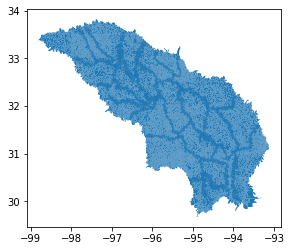

In [9]:
# Do something fancier w/ colors/HUCS
aoi_cats.plot()

#### RBI flood metrics

In [10]:
from pynhd import NLDI, WaterData
import pandas

In [41]:
# Get the RBI indicators
zip_url = 'https://pasteur.epa.gov/uploads/10.23719/1503669/NHDPlusV2_Catchment_RBI_data.zip'
#COMID should be string to keep leading 0?
#types_dict = {'COMID': str}
#df = pandas.read_csv(zip_url, dtype=types_dict)
df = pandas.read_csv(zip_url)

df

,Unnamed: 0,COMID,wet_pct,fldpop_EA,fld_pop,dasy_pop,dasypopNA,fldpct_EA,fldpct_NA,fld_pct,wetpct_up,fldpopEAd,fld_popd,dasy_popd,EA_pct_d,fld_pct_d
0,0,17683266,0.000870,0.000000,NaN,315.483781,0.000000,0.000000,0.0,0.000000,0.000870,23.479187,58.944931,775.655924,0.002066,0.010726
1,1,17683344,0.001895,10.229563,19.096540,175.924940,0.000000,0.069087,0.0,0.147868,0.000634,56.025418,111.537799,1527.749714,0.059267,0.102581
2,2,17682468,0.000659,52.024972,151.792543,269.192663,0.000000,0.148776,0.0,0.330590,0.000235,198.628844,420.293901,1348.545443,0.061818,0.130651
3,3,17683352,0.000259,10.424348,23.688638,119.623344,0.000000,0.051387,0.0,0.114931,0.000150,45.795855,92.441258,1351.824775,0.057108,0.092623
4,4,17682416,0.003562,0.052573,NaN,31.833588,0.000000,0.001684,0.0,0.000000,0.001049,1.352807,0.592492,72.121554,0.055212,0.048596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647449,68122,209959,0.000002,64.249887,NaN,730.528339,0.000000,0.108448,0.0,NaN,0.008751,98.784917,0.000000,1492.575941,0.068224,0.000000
2647450,68123,205663,0.092345,3.802999,NaN,8.545828,0.000000,0.322542,0.0,NaN,0.235496,203.904805,0.000000,225.112827,0.637635,0.098069
2647451,68124,210057,0.471229,0.000358,NaN,0.000358,0.000000,1.000000,0.0,NaN,0.143033,218.143964,0.000000,509.210208,0.574459,0.000000
2647452,68125,207323,0.000000,0.000000,NaN,0.000000,0.000000,0.963682,0.0,NaN,0.150254,0.000000,0.000000,0.000000,0.994389,0.000000


In [12]:
# Join to catchments
aoi_cats_RBI = aoi_cats.merge(df, left_on='featureid', right_on='COMID', how='left')
aoi_cats_RBI

,geometry,gridcode,featureid,sourcefc,areasqkm,shape_length,shape_area,huc8,Unnamed: 0,COMID,...,dasypopNA,fldpct_EA,fldpct_NA,fld_pct,wetpct_up,fldpopEAd,fld_popd,dasy_popd,EA_pct_d,fld_pct_d
0,"MULTIPOLYGON (((-93.51483 31.56733, -93.51764 ...",1599168,9533679,NHDFlowline,32.653905,0.360623,0.003103,12010004,9336,9533679,...,0.0,0.228339,0.0,NaN,0.048011,59.191709,0.000000,685.780646,0.279506,0.000000
1,"MULTIPOLYGON (((-93.53731 31.68345, -93.53730 ...",1599229,9533365,NHDFlowline,0.736785,0.043755,0.000070,12010004,9396,9533365,...,0.0,0.366300,0.0,NaN,0.030909,6.622868,0.000000,35.247820,0.275257,0.000000
2,"MULTIPOLYGON (((-93.46836 31.72315, -93.46960 ...",1599475,9533307,NHDFlowline,3.217219,0.094551,0.000306,12010004,9641,9533307,...,0.0,0.295779,0.0,NaN,0.014981,22.252031,0.000000,236.189710,0.177592,0.000000
3,"MULTIPOLYGON (((-93.49277 31.51103, -93.49240 ...",1599502,9533537,NHDFlowline,1.920627,0.059833,0.000182,12010004,9668,9533537,...,0.0,0.000000,0.0,NaN,0.006718,7.508587,0.000000,257.814745,0.149122,0.000000
4,"MULTIPOLYGON (((-93.49277 31.51103, -93.49414 ...",1599520,9533687,NHDFlowline,22.566996,0.279411,0.002143,12010004,9686,9533687,...,0.0,0.161801,0.0,NaN,0.022680,36.543340,0.000000,462.541115,0.205624,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23633,"MULTIPOLYGON (((-94.79047 30.11325, -94.79065 ...",1610595,1512837,NHDFlowline,0.831705,0.048498,0.000078,12030203,20650,1512837,...,0.0,0.993506,0.0,1.000000,0.807087,0.206161,0.206561,0.206561,0.998430,1.000000
23634,"MULTIPOLYGON (((-94.76963 30.25652, -94.77010 ...",1610558,1513257,NHDFlowline,48.966815,0.405550,0.004592,12030203,20614,1513257,...,0.0,0.494631,0.0,0.505292,0.454514,67.932018,105.072806,491.386210,0.581553,0.611037
23635,"MULTIPOLYGON (((-94.78949 30.43424, -94.78960 ...",1610565,1512709,NHDFlowline,21.645814,0.241461,0.002033,12030203,20621,1512709,...,0.0,0.174492,0.0,0.005829,0.352203,33.713815,56.348170,236.760771,0.393769,0.292343
23636,"MULTIPOLYGON (((-94.79345 30.12275, -94.79344 ...",1610589,1512817,NHDFlowline,0.322762,0.029475,0.000030,12030203,20645,1512817,...,0.0,1.000000,0.0,1.000000,0.916552,0.204283,0.204683,0.204683,0.998168,1.000000


In [13]:
# Columns in the dataset
aoi_cats_RBI.columns

Index(['geometry', 'gridcode', 'featureid', 'sourcefc', 'areasqkm',
       'shape_length', 'shape_area', 'huc8', 'Unnamed: 0', 'COMID', 'wet_pct',
       'fldpop_EA', 'fld_pop', 'dasy_pop', 'dasypopNA', 'fldpct_EA',
       'fldpct_NA', 'fld_pct', 'wetpct_up', 'fldpopEAd', 'fld_popd',
       'dasy_popd', 'EA_pct_d', 'fld_pct_d'],
      dtype='object')

What does this short-hand mean?

In [14]:
# Data dictionary from txt
desc_url = 'https://pasteur.epa.gov/uploads/10.23719/1503669/documents/NHDPlusV2_Catchment_RBI_data_data_table.txt'

In [15]:
# Data dictionary as table
desc = pandas.read_csv(desc_url)
desc = desc.rename(columns={"\tRow number starting at 0": "Field"})
desc['Description'] = [x.split('\t')[1] for x in desc['Field']]
desc['Field'] = [x.split('\t')[0] for x in desc['Field']]
desc

,Field,Description
0,COMID,Catchment FeatureID
1,wet_pct,Percent of wetlands in catchment
2,fldpop_EA,Catchment population in flood-prone area (USEPA)
3,fld_pop,Catchment population in flood-prone area (FEMA)
4,dasy_pop,Dasymetric population in catchment
5,dasypopNA,Percent missing data for Dasymetric population...
6,fldpct_EA,Percent flood-prone area in catchment (USEPA)
7,fldpct_NA,Perecnt missing data for flood-prone area in ...
8,fld_pct,Percent flood-prone area in catchment (FEMA)
9,wetpct_up,Percent of wetlands in catchments 5 km upstream


In [49]:
desc[desc['Field'] == 'dasypopNA']['Description'].iloc[0]

'Percent missing data for Dasymetric population in catchment'

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

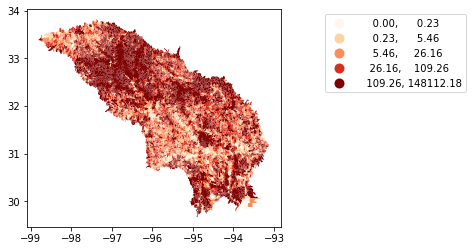

In [16]:
# Map population
#aoi_cats_RBI.plot(column='dasy_pop')
aoi_cats_RBI.plot(column='dasy_pop', cmap='OrRd', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.2f}", 'bbox_to_anchor':(1.75, 1)})

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

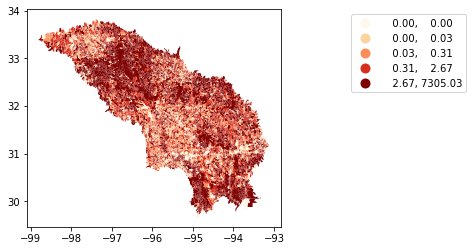

In [17]:
# Map demand
aoi_cats_RBI.plot(column='fldpop_EA', cmap='OrRd', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.2f}", 'bbox_to_anchor':(1.75, 1)})

/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

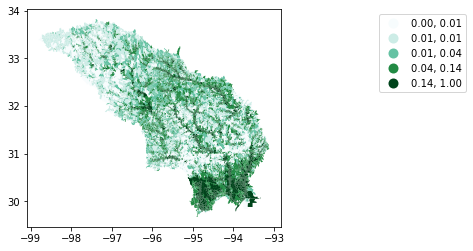

In [18]:
# Map scarcity
aoi_cats_RBI.plot(column='wet_pct', cmap='BuGn', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.2f}", 'bbox_to_anchor':(1.75, 1)})

In [19]:
# Aggregate up to HUC-8
# Note: right now this is all catchments that intersect at all
aoi_huc_RBI = aoi_cats_RBI.groupby('huc8').mean()
aoi_huc_RBI = aoi_huc08.merge(aoi_huc_RBI, left_on='huc8', right_on='huc8', how='left')
aoi_huc_RBI

,geometry,id,ogc_fid,tnmid,metasource,sourcedata,sourceorig,sourcefeat,loaddate,gnis_id,...,dasypopNA,fldpct_EA,fldpct_NA,fld_pct,wetpct_up,fldpopEAd,fld_popd,dasy_popd,EA_pct_d,fld_pct_d
0,"MULTIPOLYGON (((-93.96285 32.22747, -93.96155 ...",huc08.706,706,{30C74206-557A-450F-B887-BFA41368FAE9},None,None,None,None,2012-06-11Z,None,...,0.00000,0.279043,0.0,0.272833,0.053260,11.584180,1.765133,206.102427,0.325108,0.043762
1,"MULTIPOLYGON (((-96.20544 33.31834, -96.20324 ...",huc08.821,821,{77009020-6339-491C-9456-A791D073D4FA},None,None,None,None,2012-06-11Z,None,...,0.00000,0.224477,0.0,0.270561,0.057071,12.474037,20.935739,506.115580,0.285363,0.305837
2,"MULTIPOLYGON (((-95.35309 33.01730, -95.35100 ...",huc08.822,822,{95330B3E-9F51-4659-96FF-2B29A16DE69A},None,None,None,None,2012-06-11Z,None,...,0.00000,0.241221,0.0,0.237864,0.065788,17.336672,19.970838,627.101715,0.272175,0.193382
3,"MULTIPOLYGON (((-95.81944 33.14288, -95.81879 ...",huc08.823,823,{5B9654DB-FD15-4030-90EB-F9561FB7E9A0},None,None,None,None,2012-06-11Z,None,...,0.00000,0.234421,0.0,0.276828,0.064187,6.371669,8.135717,194.296444,0.300469,0.303211
4,"MULTIPOLYGON (((-93.36965 31.56357, -93.36967 ...",huc08.1633,1633,{C6163825-36ED-4ED3-B8BF-E454892F8B9A},None,None,None,None,2012-06-11Z,None,...,0.00000,0.448441,0.0,0.454897,0.159451,44.255205,11.897689,287.401878,0.418629,0.257234
5,"MULTIPOLYGON (((-95.69059 32.53938, -95.69027 ...",huc08.824,824,{DF67FC4B-79F8-47C8-BB8B-7E6F9FDCFF62},None,None,None,None,2012-06-11Z,None,...,0.00000,0.177934,0.0,0.219344,0.045317,14.805652,18.317765,480.605253,0.199174,0.216588
6,"MULTIPOLYGON (((-95.05318 31.71634, -95.05341 ...",huc08.825,825,{73644932-EBDE-4559-ACEB-2DB9C78ECD6C},None,None,None,None,2012-06-11Z,None,...,0.00000,0.315477,0.0,0.379221,0.098158,6.159181,8.500593,149.754033,0.304751,0.304880
7,"MULTIPOLYGON (((-94.34179 31.15760, -94.34065 ...",huc08.826,826,{596D53E8-450D-4BBD-83CA-5B6ABF8BBE5E},None,None,None,None,2012-06-11Z,None,...,0.00000,0.508729,0.0,0.503140,0.242932,70.847463,14.413751,720.777006,0.502398,0.373828
8,"MULTIPOLYGON (((-95.07467 32.36838, -95.07360 ...",huc08.827,827,{5EF1AE85-807D-4F5F-A10E-A5711C7027BC},None,None,None,None,2012-06-11Z,None,...,0.00000,0.291081,0.0,0.328515,0.084049,13.978715,16.989955,511.518766,0.278166,0.285908
9,"MULTIPOLYGON (((-94.61744 31.97462, -94.61692 ...",huc08.828,828,{193FCB5D-FCD4-40E8-9738-170E789DA6AF},None,None,None,None,2012-06-11Z,None,...,0.00000,0.276947,0.0,0.281321,0.050336,16.457036,12.197486,310.906412,0.311349,0.179557


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

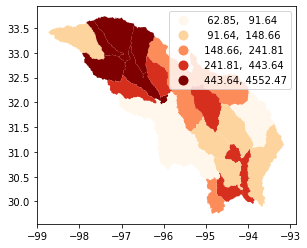

In [20]:
# Plot it
aoi_huc_RBI.plot(column='dasy_pop', cmap='OrRd', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.2f}", 'bbox_to_anchor':(1, 1)})

#### Upstream/downstream Routing

In [21]:
from collections import deque, defaultdict
from pynhd import NLDI, WaterData

In [22]:
# functions from RBI supplemental materials csvAnalysis.py
def setNHD_dict(df_flow):
    """Read in NHD Relates
    Purpose: read the upstream/downstream table to memory
    The returned dictionaries UpCOMs/DownComs can be quiered by COMID as the
    key to return a list of catchments directly upstream/downstream.
    Example: DownCOMs[1736286] returns [1737208]"""
    UpCOMs = defaultdict(list)
    DownCOMs = defaultdict(list)
    
    toList = list(df_flow['TOCOMID'])
    fromList = list(df_flow['FROMCOMID'])

    for i, toCOM in enumerate(toList):
        if toCOM != 0:
            fromCOM = fromList[i]
            if fromCOM != 0: 
                UpCOMs[toCOM].append(fromCOM)
                DownCOMs[fromCOM].append(toCOM)
    return UpCOMs, DownCOMs


def children(token, tree, limit = None, limitType = None, lengthDict = None):
    """List children
    Purpose: returns list of all children"""
    visited = set()
    to_crawl = deque([token])
    i=0
    dist = 0.0
    while to_crawl:
        current = to_crawl.popleft()
        if current in visited:
            continue
        visited.add(current)
        node_children = set(tree[current])
        to_crawl.extendleft(node_children - visited)
        if limitType is not None and limit is not None:
            if limitType == "count":
                if i >= limit:
                    return list(visited)
                else:
                    i+=1
            if limitType == "distance":
                if dist > limit:
                    return list(visited)
                else:
                    for reach in (node_children - visited):
                        dist += lengthDict[reach]
    return list(visited)


def streamlength_dict(df):
    """Assemble dictionary of COMID stream lengths
    """
    comLength = {}
    
    lenList = df['LENGTHKM']
    idList = df['COMID']
    for i, ID in enumerate(idList):
        length = float(lenList[i])
        comLength[ID] = length
    return comLength

Start by reproducing the 5km metric to understand built-in assumptions

In [23]:
# Add length from NHD flowlines to RBI catchments
flines = WaterData(layer="nhdflowline_network")
# df of flines for comids in aoi_cats_RBI
df_flines = flines.byid('comid', aoi_cats_RBI['COMID'].to_list())
df_flines.set_index(['comid'], inplace=True)  # Set index
flines_length = df_flines['lengthkm']  # Reduce df to serie
#aoi_cats_RBI['LENGTHKM'] = [flines.byid('comid', comid)['lengthkm'][0] for comid in aoi_cats_RBI['COMID']]
aoi_cats_RBI = aoi_cats_RBI.join(flines_length, on='COMID')

In [24]:
# Do comparison on first comid
aoi_cats_RBI.iloc[0]

geometry        MULTIPOLYGON (((-93.514829 31.567328, -93.5176...
gridcode                                                  1599168
featureid                                                 9533679
sourcefc                                              NHDFlowline
areasqkm                                                32.653905
shape_length                                             0.360623
shape_area                                               0.003103
huc8                                                     12010004
Unnamed: 0                                                   9336
COMID                                                     9533679
wet_pct                                                  0.057074
fldpop_EA                                               56.068449
fld_pop                                                       NaN
dasy_pop                                               637.368084
dasypopNA                                                     0.0
fldpct_EA 

In [25]:
# get one comid from df
comid = str(aoi_cats_RBI['COMID'][0])
comid

'9533679'

In [26]:
# 5km downstream dasymetric population
aoi_cats_RBI['dasy_popd'][0]

685.7806458535

In [27]:
#length of current segment
len_cat = aoi_cats_RBI['lengthkm'][0]
len_cat

9.32

In [28]:
# lenth of current segment in km by projecting to USA_Contiguous_Equidistant_Conic
#aoi_cats_RBI['LENGTHKM'] = aoi_cats_RBI.to_crs('ESRI:102005').length/1000.0
#aoi_cats_RBI['LENGTHKM'][0]
#TODO: these are catchment, need flowlines

In [29]:
#cat = nldi.getcharacteristic_byid(comid, char_type='local')
#nldi.getcharacteristic_byid(feature_ids=comid, fsource="comid",)

In [30]:
def network_aggregate(df, navigation, agg_method):
    '''
    navigation="downstreamMain"
    '''
    comid = str(df['COMID'][0])
    catchment_flow_length = df['lengthkm'][0]
    nldi = NLDI()
    flw_main = nldi.navigate_byid(fsource="comid",
                                  fid=comid,
                                  navigation=navigation,
                                  source="flowlines",
                                  distance=5+catchment_flow_length,
                                 )
    #get list of downstream ids
    downstream_ids = flw_main['nhdplus_comid'].to_list()
    #downstream_ids.remove(comid)  # include original comid in this case
    downstream_ids = [int(x) for x in downstream_ids]  # int all comids
    # agg method
    if agg_method == 'sum':
        return df[df['COMID'].isin(downstream_ids)]['dasy_pop'].sum()
    

In [31]:
# see https://docs.hyriver.io/readme/pynhd.html
#pynhd uses prepare_nhdplus
#vaa = nhd.nhdplus_vaa("input_data/nhdplus_vaa.parquet")
nldi = NLDI()
# distance should be current catchment + 5km (9.9 is too short, 10 work)
flw_main = nldi.navigate_byid(fsource="comid",
                              fid=comid,
                              navigation="downstreamMain",
                              source="flowlines",
                              distance=5+len_cat,
                              trim_start=True,
                             )


In [32]:
flw_main

,geometry,nhdplus_comid
0,"LINESTRING (-93.45417 31.61366, -93.45457 31.6...",9533679
1,"LINESTRING (-93.51167 31.56537, -93.51175 31.5...",9533497
2,"LINESTRING (-93.51462 31.56210, -93.51561 31.5...",9533509


<AxesSubplot:>

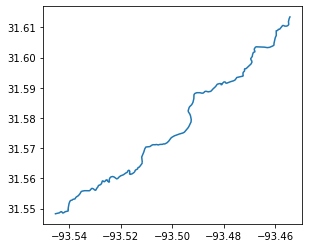

In [33]:
flw_main.plot()

In [34]:
#get list of downstream ids
downstream_ids = flw_main['nhdplus_comid'].to_list()
# include original comid in this case
#downstream_ids.remove(comid)
# int all comids
downstream_ids = [int(x) for x in downstream_ids]

In [35]:
aoi_cats_RBI[aoi_cats_RBI['COMID'].isin(downstream_ids)]['dasy_pop'].sum()

685.7806458535

In [36]:
network_aggregate(aoi_cats_RBI, navigation="downstreamMain", agg_method='sum')

685.7806458535

In [37]:
48.4125622765 + 637.368084

685.7806462765

#### Data directly from census

Boundary units are different, we need to go from hydrologically defined (NHD) to jurisdictionally defined (census)

In [38]:
import matplotlib.pyplot as plt

##### Cenpy

One of the advantages of Cenpy is it's ability to use fuzzy matching to identify boundaries by name and to search the many census data products

In [39]:
import cenpy

ModuleNotFoundError: No module named 'cenpy'

In [ ]:
# Explore what is available for what vintage
explore = cenpy.explorer.available()
explore[explore['vintage']==2021]['description']

In [ ]:
# Generate connection to ACS 5-year detailed table to see the available geographies
conn = cenpy.remote.APIConnection('ACSDT5Y2021')
conn.geographies['fips']

In [ ]:
# Get specific ACS vintage
acs_2021 = cenpy.products.ACS(2021)
# confirm object includes 'blockgroup'
acs_2021._layer_lookup.keys()

###### Retrieve geometry and data using county name

In [ ]:
# Get specific ACS vintage
acs_2021 = cenpy.products.ACS(2021)

In [ ]:
# Retrieve population ('B01001_001E') by blockgroup for 'Sussex County DE'
gdf = acs_2021.from_county("Sussex County, DE",
                     level='blockgroup',
                     variables='B01001_001E')

In [ ]:
# Map it (dropping nan)
fig, ax = plt.subplots(1,1,figsize=(20,20))
gdf.dropna(subset=['B01001_001E'], axis=0).plot('B01001_001E', ax=ax, cmap='plasma', legend=True)

###### Retrieve geometry and data using hydro bounding box

In [ ]:
# Get specific ACS vintage
acs_2021 = cenpy.products.ACS(2021)

In [ ]:
# Use hydro geometry to get census geometry and data
geoms, data = acs_2021._from_bbox(bounding_box=aoi_cats.total_bounds,
                                  level='blockgroup',
                                  variables=['B01001_001E'])

In [ ]:
# join it
data['GEOID'] = data['state'] + data['county'] + data['tract'] + data['block group']
bgs = geoms.join(data.set_index('GEOID'), on='GEOID')

In [ ]:
# Plot it
fig, ax = plt.subplots(1,1,figsize=(20,20))
bgs.dropna(subset=['B01001_001E'], axis=0).plot('B01001_001E', ax=ax, cmap='plasma', legend=True)

##### pygris

pygris is a port of the R package tigris and is mainly focused on census geometries, giving additional options like clipping out water

###### Retrieve geometry and data using county name

In [ ]:
import pygris
from pygris import counties
from pygris.data import get_census

In [ ]:
# Query geometry by name
geo_sussex = pygris.block_groups(state = "DE", county = "Sussex", year = 2021)
geo_sussex

In [ ]:
# Query population results for block groups in above county
df_sussex = get_census(dataset = "acs/acs5",
                       variables = 'B01001_001E',
                       year=2021,
                       params = {
                                 "for": "block group:*",
                                 "in": "state:10;county:005;tract:*"
                                 }, 
                       return_geoid = True)

In [ ]:
# join population to geometry
gdf_sussex = geo_sussex.join(df_sussex.set_index('GEOID'), on='GEOID')

In [ ]:
# Plot it
fig, ax = plt.subplots(1,1,figsize=(20,20))
gdf_sussex.dropna(subset=['B01001_001E'], axis=0).plot('B01001_001E', ax=ax, cmap='plasma', legend=True)

###### Retrieve geometry and data using hydro bounding box

In [ ]:
# Use hydro geometry to get census county geometries
hydro_counties = pygris.counties(subset_by=tuple(aoi_cats.total_bounds.tolist()))
hydro_counties

In [ ]:
# Plot it
hydro_counties.plot()

In [ ]:
# loop over state county combinations to query block groups geo and data
bgs=[]
for state in set(hydro_counties['STATEFP']):
    county_FIPS = list(hydro_counties[hydro_counties['STATEFP']==state]['COUNTYFP'])
    # Get block group geos
    bgs_geos = pygris.block_groups(state = state, county = county_FIPS, year = 2021)
    # Get data
    bgs_data = get_census(dataset = "acs/acs5",
                          variables = 'B01001_001E',
                          year=2021,
                          params = {
                                    "for": "block group:*",
                                    "in": "state:{};county:{};tract:*".format(state, ','.join(county_FIPS))
                                    }, 
                          return_geoid = True)
    # Join and append to running list
    bgs.append(bgs_geos.join(bgs_data.set_index('GEOID'), on='GEOID'))
gdf = pandas.concat((bgs), sort=False, axis=0)
gdf

In [ ]:
# Plot it
fig, ax = plt.subplots(1,1,figsize=(20,20))
gdf.dropna(subset=['B01001_001E'], axis=0).plot('B01001_001E', ax=ax, cmap='plasma', legend=True)

### Vulnerability Metrics

For now just show two indicator sets 'vulnerability' and 'Social Vulnerability Index'. Both have functions '_variables()' to retrieve and '_preprocess()' to process metrics.

Currently implemented using cenpy

#### Vulnerability

##### Functions

In [ ]:
def vulnerability_variables(subset=None):
    x = {'tot_pop': ['B01001_001E'],
         'age_portion': ['B01001_003E', 'B01001_020E', 'B01001_021E',
                         'B01001_022E', 'B01001_023E', 'B01001_024E',
                         'B01001_025E',
                         'B01001_027E', 'B01001_044E', 'B01001_045E',
                         'B01001_046E', 'B01001_047E', 'B01001_048E',
                         'B01001_049E'],
         'white': ['B02001_002E'],
         'income': ['B19301_001E'],
         'edu': ['B15003_001E', 'B15003_017E', 'B15003_018E', 'B15003_019E',
                 'B15003_020E', 'B15003_021E',
                 'B15003_022E', 'B15003_023E', 'B15003_024E', 'B15003_025E'],
         'pov': ["B17010_001E", "B17010_002E"],
         'tot_households': ['B25003_001E', "B25044_001E"],
         'no_car': ["B25044_003E", "B25044_010E"],
         'lang': ["C16002_004E", "C16002_007E", "C16002_010E", "C16002_013E"],
         'occupancy': ["B25014_006E", "B25014_007E", "B25014_012E",
                       "B25014_013E"],
         'employment': ["B23025_001E", "B23025_005E"],
         'renters': ["B25003_003E"],
         'parents': ['B09002_001E', 'B09002_008E'],
         'house_value': ["B25077_001E"],
         'plumbing': ['B25047_001E', 'B25047_003E'],
         'internet': ["B28003_005E", "B28003_006E"],
         'mobility': ['B07201_001E', 'B07201_007E', 'B07201_010E',
                      'B07201_013E', 'B07201_014E'],
         }
    if subset:
        return x[subset]
    else:
        # Flatten
        return [val for sublist in list(x.values()) for val in sublist]

In [ ]:
def vulnerability_preprocess(df):
    # Calculations based on total population
    tot_pop = vulnerability_variables('tot_pop')[0]
    df['age_dependence'] = sum_percent(df, 'age_portion', tot_pop)
    #x_series = df[vulnerability_variables('age_portion')].sum(axis=1)
    #df['age_dependence'] = x_series.divide(df[tot_pop])
    x_series = df[tot_pop] - df[vulnerability_variables('white')[0]]
    df['non_white'] = x_series.divide(df[tot_pop])

    # Calculations based on total households
    tot_house = vulnerability_variables('tot_households')[0]
    df['no_car'] = sum_percent(df, 'no_car', tot_house)
    #x_series = df[vulnerability_variables('no_car')].sum(axis=1)
    #df['no_car'] = x_series.divide(df[tot_house])
    df['limited_english'] = sum_percent(df, 'lang', tot_house)
    #x_series = df[vulnerability_variables('lang')].sum(axis=1)
    #df['limited_english'] = x_series.divide(df[tot_house])
    df['internet'] = sum_percent(df, 'internet', tot_house)
    #x_series = df[vulnerability_variables('internet')].sum(axis=1)
    #df['internet'] = x_series.divide(df[tot_house])
    df['crowded'] = sum_percent(df, 'occupancy', tot_house)
    df['renters'] = sum_percent(df, 'renters', tot_house)

    # One value for denominator (must be first)
    df['parents'] = divide_list(df, 'parents')
    df['plumbing'] = divide_list(df, 'plumbing')
    df['poverty'] = divide_list(df, 'pov')
    df['unemployed'] = divide_list(df, 'employment')
    # values >2
    df['mobility'] = divide_list(df, 'mobility')

    # List but inverse value
    edu = vulnerability_variables('edu')
    x_series = df[edu[0]] - df[edu[1:]].sum(axis=1)
    df['no_diploma_GED'] = x_series.divide(df[edu[0]])

    # non-percents
    df['income'] = df[vulnerability_variables('income')]
    df['house_value'] = df[vulnerability_variables('house_value')]

    # Infer missing values from tract
    # this seems to just be a house values

    # min-max standardized values
    df['std_income'] = standardize_val(df['income'])
    df['std_house_value'] = standardize_val(df['house_value'])

    # Individual Vulnerability
    # AVG[(Q_AgeDep)  (Q_NW)  (Q_Move)  (Q_NoEd)  (Inv_PCInc)  (Q_Unemp)]
    cols = ['age_dependence', 'non_white', 'mobility', 'no_diploma_GED',
            'std_income', 'unemployed']
    df['Indiv_Vuln'] = df[cols].mean(axis=1)

    # Family Vulnerability
    # AVG[(Q_SPH)  (Q_Rent)  (Q_Pov)  (Q_NoVeh)  (Q_LimEng)]
    cols = ['parents', 'renters', 'poverty', 'no_car', 'limited_english']
    df['Fam_Vuln'] = df[cols].mean(axis=1)

    # Household Vulnerability
    # AVG[(Q_Crowd)  (Q_LackPlumb)  (Std_MHHVal)  (Q_NoInt)]
    cols = ['crowded', 'plumbing', 'std_house_value', 'internet']
    df['Hous_Vuln'] = df[cols].mean(axis=1)

    # Social Vulnerability
    #SUM[(Indiv_Vuln) (Fam_Vuln) (Hous_Vuln)]
    df['Soc_Vuln'] = df[['Indiv_Vuln', 'Fam_Vuln', 'Hous_Vuln']].sum(axis=1)

    return df

In [ ]:
def standardize_val(series):
    """min-max standardized value for pandas.series"""
    s_min = series.min()
    s_max = series.max()
    return [1-((x-s_min)/(s_max-s_min)) for x in series]


def divide_list(df, key):
    """ Must be total (denominator) followed by portion (numerator)"""
    vals = vulnerability_variables(key)
    # For a longer list the numerator is the sum of all but first value
    if len(vals) > 2:
        return df[vals[1:]].sum(axis=1).divide(df[vals[0]])
    # Else the numerator is the second and last value in the list
    return df[vals[1]].divide(df[vals[0]])


def sum_percent(df, cols_key, tot_col):
    """Add up all values in cols_key  and divide by tot_col"""
    x_series = df[vulnerability_variables(cols_key)].sum(axis=1)
    return x_series.divide(df[tot_col])

Documentation/explanation (need to investigate if this could come from cenpy)

In [ ]:
# B01001 – Age dependence (<5 and >65) % total pop
#tot_pop = Total sex by age: B01001_001E
#age_male:['B01001_003E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E']
#"Estimate!!Total:!!Male:!!Under 5 years": B01001_003E
#"Estimate!!Total:!!Male:!!65 and 66 years": B01001_020E
#"Estimate!!Total:!!Male:!!85 years and over": B01001_025E
#age_female:['B01001_027E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E']
#"Estimate!!Total:!!Female:!!Under 5 years": B01001_027E
#"Estimate!!Total:!!Female:!!65 and 66 years": B01001_044E
#"Estimate!!Total:!!Female:!!85 years and over": B01001_049E 
#age_portion = age_male + age_female

In [ ]:
#B02001 – Race - % non-white
#Total: B02001_001E = tot_pop
#"Estimate!!Total:!!White alone": B02001_002E
#white = ['B02001_002E']

In [ ]:
# B19301 – Per capita Income
#"Estimate!!Per capita income in the past 12 months (in 2019 inflation-adjusted dollars)": B19301_001E
#income = ['B19301_001E']

In [ ]:
# B15003 – Educational Attainment - % over 25 without HS diploma/GED
# Concept: "EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER"
# Total 'B15003_001E'
#tot_edu = ['B15003_001E']
# "Estimate!!Total:!!No schooling completed": B15003_002E
# "Estimate!!Total:!!Nursery school": B15003_003E
# "Estimate!!Total:!!12th grade, no diploma": B15003_016E
# Faster to get categories GED/diploma +
# "Estimate!!Total:!!Regular high school diploma": B15003_017E
# "Estimate!!Total:!!GED or alternative credential": B15003_018E
# "Estimate!!Total:!!Doctorate degree": B15003_025E
#edu = ['B15003_017E', 'B15003_018E', 'B15003_019E', 'B15003_020E', 'B15003_021E', 'B15003_022E', 'B15003_023E', 'B15003_024E', 'B15003_025E']

In [ ]:
# B17010 – Poverty - % households below poverty level
# Concept: "POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY PRESENCE OF RELATED CHILDREN UNDER 18 YEARS BY AGE OF RELATED CHILDREN"
# "Estimate!!Total:" B17010_001E
# "Estimate!!Total:!!Income in the past 12 months below poverty level:" B17010_002E
# "Estimate!!Total:!!Income in the past 12 months below poverty level:!!Married-couple family:" B17010_003
#pov = ["B17010_001E", "B17010_002E"]

In [ ]:
# B25044 - Vehicles at household - % households with no vehicles
# "concept": "TENURE BY VEHICLES AVAILABLE"
# "Estimate!!Total:!!Owner occupied:": B25044_002E
# "Estimate!!Total:!!Owner occupied:!!No vehicle available": B25044_003E
# "concept": "HOUSEHOLD SIZE BY VEHICLES AVAILABLE"
#"Estimate!!Total:": B08201_001E
#"Estimate!!Total:!!No vehicle available": B08201_002E
#tot_households = ["B08201_001E"]
#no_vehicles = ["B08201_002E"]

In [ ]:
# C16002 – Language – percent households with limited English proficiency
# "concept": "HOUSEHOLD LANGUAGE BY HOUSEHOLD LIMITED ENGLISH SPEAKING STATUS"
# "Estimate!!Total:" C16002_001E
# "Estimate!!Total:!!Spanish:!!Limited English speaking household": C16002_004E
# "Estimate!!Total:!!Other Indo-European languages:!!Limited English speaking household": C16002_007E
# "Estimate!!Total:!!Asian and Pacific Island languages:!!Limited English speaking household": C16002_010E
# "Estimate!!Total:!!Other languages:!!Limited English speaking household": C16002_013E
#lang = ["C16002_004E", "C16002_007E", "C16002_010E", "C16002_013E"]

In [ ]:
# B25014 – Occupancy - % overcrowded housing (>2 occupants per room)
# "concept": "TENURE BY OCCUPANTS PER ROOM"
# "Estimate!!Total:!!Owner occupied:!!1.51 to 2.00 occupants per room": B25014_006E
# "Estimate!!Total:!!Owner occupied:!!2.01 or more occupants per room": B25014_007E
# "Estimate!!Total:!!Renter occupied:!!1.51 to 2.00 occupants per room": B25014_012E
# "Estimate!!Total:!!Renter occupied:!!2.01 or more occupants per room": B25014_013E

# For more context:
# "Estimate!!Total:" B25014_001E
# "Estimate!!Total:!!Owner occupied:" B25014_002E
# "Estimate!!Total:!!Renter occupied:": B25014_008E
#occupancy = ["B25014_007E",  "B25014_013E"]

In [ ]:
# B23025 – Employment % unemployed
# "concept": "EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER"
# "label": "Estimate!!Total:" B23025_001E
#"Estimate!!Total:!!In labor force:!!Civilian labor force:!!Unemployed": B23025_005E
#"Estimate!!Total:!!Not in labor force": B23025_007E  # Not included
#employment = ["B23025_001E", "B23025_005E"]

In [ ]:
# B25003 – renters - % renter occupied (Universe occupied housing)
# "Estimate!!Total:": B25003_001E
# "Estimate!!Total:!!Renter occupied": B25003_003E
#rent = ["B25003_003E"]

In [ ]:
# B09002 - single parent households - % SPH (univ: family households…I think)
# Concept: "OWN CHILDREN UNDER 18 YEARS BY FAMILY TYPE AND AGE"
# "Estimate!!Total:": B09002_001E != households
# "Estimate!!Total:!!In other families:" B09002_008E
# B09002_001E = B09002_002E (In married-couple families) + B09002_008E
# B09002_008E = B09002_009E (Male householder, no spouse present) + B09002_015E (Female householder, no spouse present)
#parent = ['B09002_001E', 'B09002_008E']

In [ ]:
# B25077 - Med. House Value
# "Estimate!!Median value (dollars)" B25077_001E
#val = ["B25077_001E"]

In [ ]:
# B25047 – Plumbing - % houses with incomplete plumbing facilities
# Concept: "PLUMBING FACILITIES FOR ALL HOUSING UNITS"
# "Estimate!!Total:" B25047_001E
# "Estimate!!Total:!!Lacking complete plumbing facilities" B25047_003E
#plumb = ['B25047_001E', 'B25047_003E']

In [ ]:
# B28003 - Internet/Computer - % with no internet connection
# Concept: "PRESENCE OF A COMPUTER AND TYPE OF INTERNET SUBSCRIPTION IN HOUSEHOLD"
# "Estimate!!Total:": "B28003_001E" = Total Households
#"Estimate!!Total:!!Has a computer:!!Without an Internet subscription" B28003_005E
#"Estimate!!Total:!!No computer" B28003_006E
#internet = ["B28003_005E", "B28003_006E"]

In [ ]:
# B07201 – mobility - % population who moved outside MSA within last year
# Concept: "GEOGRAPHICAL MOBILITY IN THE PAST YEAR FOR CURRENT RESIDENCE--METROPOLITAN STATISTICAL AREA LEVEL IN THE UNITED STATES"
# "Estimate!!Total:" B07201_001E
# "Estimate!!Total:!!Same house 1 year ago": B07201_002E
# "Estimate!!Total:!!Different house in United States 1 year ago:" B07201_003E
# "Estimate!!Total:!!Different house in United States 1 year ago:!!Same Metropolitan Statistical Area:" B07201_004E
# "Estimate!!Total:!!Different house in United States 1 year ago:!!Different Metropolitan Statistical Area:" B07201_007E
# "Estimate!!Total:!!Different house in United States 1 year ago:!!Micropolitan Statistical Area:" B07201_010E
# "Estimate!!Total:!!Different house in United States 1 year ago:!!Not in a Metropolitan or Micropolitan Statistical Area 1 year ago" B07201_013E
# "Estimate!!Total:!!Abroad 1 year ago" B07201_014E
#mobil = ['B07201_001E', 'B07201_007E', 'B07201_013E', 'B07201_014E']

In [ ]:
#car_vars = ['B08201_001E', 'B08541_001E', 'B08203_001E', 'B08014_001E',
#            'B25044_001E', 'B25045_001E', 'B08141_001E']

#B08201 "concept": "HOUSEHOLD SIZE BY VEHICLES AVAILABLE"
#B08541 "concept": "MEANS OF TRANSPORTATION TO WORK BY VEHICLES AVAILABLE FOR WORKPLACE GEOGRAPHY"
#B08203 "concept": NUMBER OF WORKERS IN HOUSEHOLD BY VEHICLES AVAILABLE
#B08014 "concept": "SEX OF WORKERS BY VEHICLES AVAILABLE"
#B25044 "concept": "TENURE BY VEHICLES AVAILABLE" **HAS BG data**
#B25045 "concept": "TENURE BY VEHICLES AVAILABLE BY AGE OF HOUSEHOLDER" **HAS BG data**
#B08141 "concept": "MEANS OF TRANSPORTATION TO WORK BY VEHICLES AVAILABLE",

##### Retrieved for hydrologic units

In [ ]:
acs_2021 = cenpy.products.ACS(2021)

In [ ]:
# Use hydro geometry to get census geometry and data
geoms, data = acs_2021._from_bbox(bounding_box=aoi_cats.total_bounds,
                                  level='blockgroup',
                                  variables=vulnerability_variables())

In [ ]:
# Join dfs
#TODO: join on state/county/tract instead of GEOID?
data['GEOID'] = data['state'] + data['county'] + data['tract'] + data['block group']
sf = geoms.join(data.set_index('GEOID'), on='GEOID')
sf = sf.reset_index()

In [ ]:
# Process the retrieved values
df_hydro = vulnerability_preprocess(sf)

In [ ]:
#TODO: pop100 is blank for some reason for 2021 but was fine for 2020?
#list(df_hydro.columns)
df_hydro['POP100']
#df_hydro['B01001_001E']

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
df_hydro.dropna(subset=['B01001_001E'], axis=0).plot('B01001_001E',
                                                   ax=ax,
                                                   cmap='plasma',
                                                   legend=True)

###### B01001 – Age dependence (<5 and >65) % total pop

In [ ]:
# Calculate summary percentage 'B01001 – Age dependence (<5 and >65) % total pop'
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['age_dependence'], axis=0).plot('age_dependence', ax=ax, cmap='plasma', legend=True)
#df_hydro.plot('age_dependence', ax=ax, cmap='plasma', legend=True)
# NOTE: NAs have 0 total population
#sf[sf['Age dependence percent'].isna()][tot_pop]

###### B02001 – Race - % non-white

In [ ]:
# Calculate: (total pop - white) / total pop
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['non_white'], axis=0).plot('non_white', ax=ax, cmap='plasma', legend=True)

###### B19301 – Per capita Income

In [ ]:
#sf['Income'] = sf['B19301_001E']
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['income'], axis=0).plot('income', ax=ax, cmap='plasma', legend=True)

In [ ]:
# Standardized within query
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['std_income'], axis=0).plot('std_income', ax=ax, cmap='plasma', legend=True)

###### B15003 Educational Attainment - % over 25 without HS diploma/GED

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['no_diploma_GED'], axis=0).plot('no_diploma_GED', ax=ax, cmap='plasma', legend=True)

###### B17010 – Poverty - % households below poverty level

In [ ]:
# Calculate summary percentage
# Note tot_pov (B17010_001E) is less than household total (B08201_001E)
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['poverty'], axis=0).plot('poverty', ax=ax, cmap='plasma', legend=True)

###### B25044 - Vehicles at household - % households with no vehicles

In [ ]:
# Calculate summary percentage
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['no_car'], axis=0).plot('no_car', ax=ax, cmap='plasma', legend=True)

###### C16002 – Language – percent households with limited English proficiency

In [ ]:
# Calculate summary percentage
# Note: C16002_001E = household total (B08201_001E)
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['limited_english'], axis=0).plot('limited_english', ax=ax, cmap='plasma', legend=True)

###### B25014 – Occupancy - % overcrowded housing (>2 occupants per room)

In [ ]:
# Calculate summary percentage
# Note: B25014_001E = household total (B08201_001E)
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['crowded'], axis=0).plot('crowded', ax=ax, cmap='plasma', legend=True)

###### B23025 – Employment % unemployed

In [ ]:
# Calculate summary percentage
# Note: currently includes those not in the labor force
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['unemployed'], axis=0).plot('unemployed', ax=ax, cmap='plasma', legend=True)

###### B25003 – renters - % renter occupied (Universe occupied housing)

In [ ]:
# Calculate summary percentage
# Note: B25003_001E = Total households
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['renters'], axis=0).plot('renters', ax=ax, cmap='plasma', legend=True)

###### B09002 - single parent households - % SPH (univ: family households…I think)

In [ ]:
# Calculate summary percentage
# Note: B09002_001E != Total households
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['parents'], axis=0).plot('parents', ax=ax, cmap='plasma', legend=True)

###### B25077 - Med. House Value

In [ ]:
# Calculate summary percentage
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['house_value'], axis=0).plot('house_value', ax=ax, cmap='plasma', legend=True)

In [ ]:
# min-max standardize
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['std_house_value'], axis=0).plot('std_house_value', ax=ax, cmap='plasma', legend=True)

###### B25047 – Plumbing - % houses with incomplete plumbing facilities

In [ ]:
# Calculate summary percentage
# Note: B25047_001E != Total households'
# sf[tot_households + plumb].iloc[1243]
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['plumbing'], axis=0).plot('plumbing', ax=ax, cmap='plasma', legend=True)

###### B28003 - Internet/Computer - % with no internet connection

In [ ]:
# Calculate summary percentage
# Note: B28003_001E = Total households
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['internet'], axis=0).plot('internet', ax=ax, cmap='plasma', legend=True)

###### B07201 – mobility - % population who moved outside MSA within last year

In [ ]:
# Calculate summary percentage
# Some weirdness w/ many 0 or NA where people haven't moved?
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['mobility'], axis=0).plot('mobility', ax=ax, cmap='plasma', legend=True)

###### Summary indices

In [ ]:
# Individual vulnerability
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['Indiv_Vuln'], axis=0).plot('Indiv_Vuln', ax=ax, cmap='plasma', legend=True)

In [ ]:
# Family vulnerability
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['Fam_Vuln'], axis=0).plot('Fam_Vuln', ax=ax, cmap='plasma', legend=True)

In [ ]:
# Household vulnerability
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['Hous_Vuln'], axis=0).plot('Hous_Vuln', ax=ax, cmap='plasma', legend=True)

In [ ]:
# Overal social vulnerability
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['Soc_Vuln'], axis=0).plot('Soc_Vuln', ax=ax, cmap='plasma', legend=True)

#### SVI

##### Functions

In [ ]:
# SVI dict
def SVI_variables(subset=None):
    #'QLIMENG': ['B16004_0{}E'.format(str(x).zfill(2)) for x in range(1, 68)],
    x = {'POP': ['B01003_001E'],
         'HH': ['B25003_001E'],
         'QHH200K': ['B19001_001E', 'B19001_017E'],
         'MHHVAL': ['B25077_001E'],
         'MGRENT': ['B25064_001E'],
         'PCINC': ['B19301_001E'],
         'QASIAN': ['B02001_001E', 'B02001_005E'],
         'QBLACK': ['B02001_001E', 'B02001_003E'],
         'QFHHLD': ['B09019_003E', 'B09019_008E', 'B09019_009E'],
         'QPOV': ['B17021_001E', 'B17021_002E'],
         'QNOED': ['B15003_001E',
                   'B15003_017E', 'B15003_018E',
                   'B15003_019E', 'B15003_020E',
                   'B15003_021E', 'B15003_022E',
                   'B15003_023E', 'B15003_024E',
                   'B15003_025E'],
         'QNOVEH': ['B25044_001E', 'B25044_003E', 'B25044_010E'],
         'QFAM': ['B11003_001E', 'B11003_003E'],
         'MAGE': ['B01002_001E'],
         'QSSBEN': ['B19055_001E', 'B19055_002E'],
         'QAGEDEP': ['B01001_001E', 'B01001_003E', 'B01001_027E',
                     'B01001_020E', 'B01001_021E',
                     'B01001_022E', 'B01001_023E',
                     'B01001_024E', 'B01001_025E',
                     'B01001_044E', 'B01001_045E',
                     'B01001_046E', 'B01001_047E',
                     'B01001_048E', 'B01001_049E'],
         'QUNOCC': ['B25002_001E', 'B25002_003E'],
         'QRENT': ['B25008_001E', 'B25008_003E'],
         'QHISP': ['B03003_001E', 'B03003_003E'],
         'QLIMENG': ['B16004_001E',
                     'B16004_007E', 'B16004_008E', 'B16004_012E', 'B16004_013E',  'B16004_017E', 'B16004_018E', 'B16004_022E', 'B16004_023E', 
                     'B16004_029E', 'B16004_030E', 'B16004_034E', 'B16004_035E', 'B16004_039E', 'B16004_040E', 'B16004_044E', 'B16004_045E', 
                     'B16004_051E', 'B16004_052E', 'B16004_056E', 'B16004_057E', 'B16004_061E', 'B16004_062E', 'B16004_066E', 'B16004_067E', 
                    ],
         'QNOINS': ['B27010_001E', 
                    'B27010_017E', 'B27010_033E', 'B27010_050E', 'B27010_066E'],
         'HHCROWD': ['B25014_001E',
                     'B25014_006E', 'B25014_007E', 'B25014_012E', 'B25014_013E'],
         'QHHBURD': ['B25091_001E',
                     'B25091_008E', 'B25091_009E', 'B25091_010E', 'B25091_011E',
                     'B25091_019E', 'B25091_020E', 'B25091_021E', 'B25091_022E'],
         'QUNEMP': ['B23025_001E', 'B23025_005E'],
         'QNATIVE': ['B02001_001E', 'B02001_004E'],
         'QFEM': ['B01001_001E', 'B01001_026E']
        }
    if subset:
        if subset in ['keys', 'indicators']:
            return list(x.keys())
        else:
            return x[subset]
    else:
        # Flatten
        return list(set([val for sublist in list(x.values()) for val in sublist]))

In [ ]:
def SVI_preprocess(df_in):
    # Deep copy table
    df = df_in.copy()
    # List new column names
    cols = SVI_variables('keys')
    
    # cols maths: just rename, percents where col2/col1, and difs where col2-col1/col1
    renames = ['POP', 'HH', 'MHHVAL', 'MGRENT', 'PCINC', 'MAGE']
    pct = ['QHH200K', 'QASIAN', 'QBLACK', 'QPOV',
           'QFAM', 'QSSBEN', 'QUNOCC', 'QRENT',
           'QHISP', 'QLIMENG', 'QNOINS', 'HHCROWD',
           'QHHBURD', 'QUNEMP', 'QNATIVE', 'QFEM',
           'QFHHLD', 'QNOVEH', 'QAGEDEP']
    pct_dif = ['QNOED']

    for col in cols:
        metric_cols = SVI_variables(col)
        if col in renames:
            df = df.rename(columns={metric_cols[0]: col})
        elif col in pct:
            if len(metric_cols)>2:
                print(col)
                # Numerator is sum of list (excluding denominator)
                df[col] = df[metric_cols[1:]].sum(axis=1).divide(df[metric_cols[0]]) *100.0
            else:
                # Numerator is last in list
                df[col] = df[metric_cols[1]].divide(df[metric_cols[0]]) *100.0
        elif col in pct_dif:
            df[col] = (df[metric_cols[0]] - df[metric_cols[1:]].sum(axis=1)).divide(df[metric_cols[0]]) *100.0
        else:
            # TODO: throw error
            print('{} has no preprocessing assigned'.format(col))
    #TODO: drop original cols?
    
    return df

##### Retrieved for hydrologic units

In [ ]:
import cenpy

# get specific ACS vintage
acs_2021 = cenpy.products.ACS(2021)

In [ ]:
# Use hydro geometry to get census geometry and data
geoms, data = acs_2021._from_bbox(bounding_box=aoi_cats.total_bounds,
                                  level='blockgroup',
                                  variables=SVI_variables())

In [ ]:
# Join dfs
#TODO: join on state/county/tract instead of GEOID?
data['GEOID'] = data['state'] + data['county'] + data['tract'] + data['block group']
sf = geoms.join(data.set_index('GEOID'), on='GEOID')
sf = sf.reset_index()

In [ ]:
# Process the retrieved values
df_hydro = SVI_preprocess(sf)

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1,figsize=(20,20))
df_hydro.dropna(subset=['POP'], axis=0).plot('POP', ax=ax, cmap='plasma', legend=True)

#### Vulnerability tests (Sussex County)

In [ ]:
# get specific ACS vintage
acs = cenpy.products.ACS(2020)

In [ ]:
df = acs.from_county("Sussex County, DE",
                     level='blockgroup',
                     variables=vulnerability_variables())

In [ ]:
df = vulnerability_preprocess(df)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
df.dropna(subset=['Soc_Vuln'], axis=0).plot('Soc_Vuln', ax=ax, cmap='plasma', legend=True)

In [ ]:
# Export to excel
df.to_csv('/arcgis/home/sussex_2020.csv')

#### SVI tests (FL counties)

In [ ]:
import cenpy

# get specific ACS vintage
acs = cenpy.products.ACS(2019)

In [ ]:
# counties in FL
FL_counties = ['BAY',
               'CALHOUN',
               'FRANKLIN',
               'GADSDEN',
               'GULF',
               'JACKSON',
               'LEON',
               'LIBERTY',
               'WAKULLA',
               'WALTON',
               'WASHINGTON']

In [ ]:
df = None
for county in FL_counties:
    county_str = '{}, {}'.format(county, 'FL')
    df_temp = acs.from_county(county_str,
                              level='blockgroup',
                              variables=SVI_variables())
    if df is None:
        df = df_temp
    else:
        df = df.append(df_temp)

In [ ]:
# Run calcs
df2 = SVI_preprocess(df)
#strip geom

In [ ]:
# reduce cols
keep_cols = ['GEOID',
             'state',
             'county',
             'tract',
             'block group',
             'NAME',
             'QHH200K',
             'QASIAN',
             'QBLACK',
             'QFHHLD',
             'QPOV',
             'QNOED',
             'QNOVEH',
             'QFAM',
             'QSSBEN',
             'QAGEDEP',
             'QUNOCC',
             'QRENT',
             'QHISP',
             'QLIMENG',
             'QNOINS',
             'HHCROWD',
             'QHHBURD',
             'QUNEMP',
             'QNATIVE',
             'QFEM']
df_out = df2[keep_cols]

In [ ]:
# Export to excel
df_out.to_csv('/arcgis/home/SVI_2019.csv')

#### pygris multi test

In [ ]:
ACS_2021_1 = get_census(dataset = "acs/acs5",
                      variables = SVI_variables()[0],
                      year=2021,
                      params = {
                                "for": "block group:*",
                                "in": "state:12;county:133;tract:*"
                                }, 
                      return_geoid = True)

In [ ]:
ACS_2021 = get_census(dataset = "acs/acs5",
                      variables = SVI_variables(),
                      year=2021,
                      params = {
                                "for": "block group:*",
                                "in": "state:12;county:133;tract:*"
                                }, 
                      return_geoid = True)

In [ ]:
[i for i, x in enumerate(SVI_variables()) if x not in list(ACS_2021.columns)]

#### Geos by geoid (Cenpy)

In [ ]:
# Functions to query by geoid
def get_FIPS(gdf, survey, year, level):
    # Note: this is hacky (using tiger_dict) and slow (gets one geom at a time)
    # transition to using Product class instead once it accepts BG
    
    # check gdf
    if not isinstance(gdf, geopandas.geodataframe.GeoDataFrame):
        gdf = geopandas.read_file(gdf)
    
    # Transfrom gdf to EPSG 3857 for query
    # Note: this is fast but could test: if gdf.crs != 
    gdf = gdf.to_crs(epsg=3857)
    
    # Geometry for query
    bbox = ','.join(map(str, gdf.total_bounds))
    
    # get layer info
    layer = tiger_dict[survey][year][level]
    base_url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_'
    url = '{}{}{}/MapServer'.format(base_url, survey, year)
    
    feature_layer = cenpy.tiger.ESRILayer(url, **{'id': layer})
    
    # query from gdf
    query_params = {"geometry": bbox,
                    "geometryType": "esriGeometryEnvelope",
                    "spatialRel": "esriSpatialRelIntersects",
                    'returnGeometry': "false",
                    "outFields": ", ".join(['GEOID', 'NAME']),
                    }
    df = feature_layer.query(**query_params)

    gdf_out = None

    for geoids in chunked(df['GEOID'], 10):
        gdf_temp = geom_by_geoids(feature_layer, geoids)
        if gdf_out is None:
            gdf_out = gdf_temp
        else:
            gdf_out = gdf_out.append(gdf_temp)
    return gdf_out


def chunked(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


def geom_by_geoids(feature_layer, geoids):
    return feature_layer.query(**{"where": "GEOID='" + "' OR GEOID='".join(geoids) + "'",
                                  "returnGeometry": "true",
                                  "outFields": ", ".join(['GEOID', 'NAME'])})


# Structure by dataset, year and layers
tiger_dict = {'ACS': {2019: {'BG': 10,
                             'Tracts': 8},
                      2021: {'BG': 8,
                             'Tracts': 6},
                     },
              'Census': {2020: {'county': 86,
                                'BG': 8},
                         2010: {'county': 100,
                                'BG': 16},
                        },
             }

In [ ]:
import copy
import geopandas
import requests
import cenpy

import matplotlib.pyplot as plt

In [ ]:
# Retrieve census block groups using catchment geometry
survey = 'ACS'
year = 2021
level = 'BG'

res = get_FIPS(aoi_cats, survey, year, level)

In [ ]:
# Plot block groups

# CRS to plot
res = res.to_crs(epsg=4326)
fig, ax = plt.subplots(dpi=300)
res.plot(ax=ax, edgecolor='k')
aoi_cats.plot(ax=ax, facecolor='none', edgecolor='red')

In [ ]:
# Plot Tracts
res['Tract']= [x[5:-1] for x in res['GEOID']]
#tract = res.groupby('Tract').count()
tract = res.dissolve(by='Tract')

In [ ]:
# CRS to plot
tract = tract.to_crs(epsg=4326)
fig, ax = plt.subplots(dpi=300)
tract.plot(ax=ax, edgecolor='k')
aoi_cats.plot(ax=ax, facecolor='none', edgecolor='red')

In [ ]:
# We have geoids from the spatial query in last section
res['GEOID']

### Updating RBI metrics

#### Wetlands

In [ ]:
# NWI
NWI_raster_url = 'https://fwspublicservices.wim.usgs.gov/wetlandsmapservice/rest/services/Wetlands_Raster/MapServer/0'
NWI_poly_url = 'https://fwspublicservices.wim.usgs.gov/wetlandsmapservice/rest/services/Wetlands/MapServer/0'

# Potentially restorable wetlands on agricultural land
PRWA_url = base_url_EA + 'PRWAg_WMerc/MapServer/0'
# Potential wetlands
PWA_url = base_url_EA + 'PWA_WMerc/MapServer/0'

# CCAP (NOAA)
layer_dict = {'american_samoa_2010_wm': 0,
              'as_east_manua_2010_wm': 1,
              'as_swains_island_2010_wm': 2,
              'as_tutuila_2010_wm': 3,
              'as_west_manua_2010_wm': 4,
              'great_lakes_2010_wm': 5,
              'gulf_coast_2010_wm': 6,
              'northeast_2010_wm': 7,
              'pacific_coast_2010_wm': 8,
              'southeast_2010_wm': 9}
CCAP_2010_url = 'https://coast.noaa.gov/arcgis/rest/services/CCAP/conus_10/MapServer/6'

In [ ]:
# StreamCat API?

#### Population from EnviroAtlas Dasymetric maps

In [ ]:
# Dasymetric (EPA)
dasy_url = base_url_EA + 'Dasymetric_WMerc/MapServer/0'

# Census
decennial = cenpy.products.Decennial2010()

# ACS
ACS_years = [2016, 2017, 2018, 2019]
ACS_variables = ['B00002*', 'B01002H_001E']
chicago = products.ACS(year).from_place('Chicago, IL',
                                        level='tract',
                                        variables=ACS_variables)

# SVI (CDC)
SVI_years = [2000, 2010, 2014, 2016, 2018]
cdc_base_url = 'svi.cdc.gov/Documents/Data/'
SVI_url = '{}{}_SVI_Data/CSV/States/{}.csv'.format(cdc_base_url, year, state)

# EJ Screen (EPA)
# Send it a FIPS code and geometry
FIPS = 120330000012
ej_base_url = 'https://ejscreen.epa.gov/mapper/ejscreenRESTbroker.aspx?'
ej_url_query = {'namestr': FIPS,
                'unit': 9035,
                'areatype': 'blockgroup',
                'areaid': FIPS,
                'f': 'pjson'}

#### Flooding

In [ ]:
# FEMA Flood Hazard Zones
FEMA_url = 'https://hazards.fema.gov/gis/nfhl/rest/services/public/NFHL/MapServer/28'

# EPA
# Image service no longer available

### Other data

In [ ]:
# H2O watershed from AOI geometry

In [ ]:
import geopandas

wbd_08 = WaterData(layer='huc08')

In [ ]:
# Define AOI
dataset = '/arcgis/home/DOlive.shp'
gdf = geopandas.read_file(dataset)

In [ ]:
# Re-project CRS to 4326
gdf = gdf.to_crs(4326)

In [ ]:
gdf['geometry'][0]

In [ ]:
HUC_08 = wbd_08.bygeom(gdf['geometry'][0])

In [ ]:
HUC_08.plot()

In [ ]:
HUC_08

In [ ]:
HUC_08.to_file('/arcgis/home/DOlive_HUC8.shp')

#### Soils

##### Functions (built into package)

In [ ]:
from zipfile import ZipFile
from json import loads


# Functions
def getSoils(FIPS, D1, D2):
    """
    FIPS: as pandas.dataframe with columns = 'ST_ABBR' and 'GEOID'
    """
    #if self.FIPs is None:
    #    self.setFIPs()

    # Source url (WSS)
    url = "https://websoilsurvey.sc.egov.usda.gov/DSD/Download/Cache/SSA/"

    # Build WSS query, download, and unpack to out_shapefile
    FIP_df = FIPS
    FIP_df['SSA'] = FIP_df['ST_ABBR'] + [x[2:5] for x in FIP_df['GEOID']]

    #TODO: I assume this was done because FIP_SSA != SSA
    #but it's not working and seems to return same for test
    SSA_list = []
    for SSA in list(set(FIP_df['SSA'])):
        SSA_list += getCounty_surveys(SSA)
    #SSA_list = list(set(FIP_df['SSA']))

    for i, SSA in enumerate(SSA_list):
        # Get latest saverest
        year, mo, da = getSurvey_date(SSA)

        # Download SSURGO by SSA, e.g. url + wss_SSA_FL113_[2017-10-06].zip
        download = "wss_SSA_{}_[{}-{}-{}].zip".format(SSA, year, mo, da)
        res = get_url(url + download)
        soils_zip = os.path.join(D1, download)
        with open(soils_zip, "wb") as f:
             f.write(res.content)
        # Check archive is valid and extract downloaded files to D2 folder
        if check_archive(soils_zip):
            z = soils_zip # shorthand for zip filename
            # soilmu_a shapefiles has multiple component files (e.g. .prj)
            #shp_root = "{0}{1}spatial{1}soilmu_a_".format(SSA, '/')
            shp_root = "{}/spatial/soilmu_a_".format(SSA)
            #list shp component files in archive
            shp_list = [f for f in archiveList(z) if shp_root in f]
            for f in shp_list:
                archiveExtract(z, f, D2) # Extract each component
                if f.endswith('.shp'): #list shapefiles
                    shp = os.path.join(D2, f.replace('/', os.sep))
            gdf_temp = as_gdf(shp)
            # Append to single geodataframe
            if i<1:
                gdf = gdf_temp
            else:
                gdf = gdf.append(gdf_temp)
    # Save gdf?
    gdf.to_file(os.path.join(D2, "AOI_Soils.shp"))

    #Start processing GDF
    # Get "hydgrp" by mukey to populate "Max_Type_N" field
    mukey_list = list(set(gdf["MUKEY"]))  # Unique mukey list

    # Create dictionary where mukey:first hydrgrps
    soil_dict = {key: getMUKEY_val(key, "hydgrp")[0] for key in mukey_list}
    # Reduce dual soil hydrgrps to first, leaving None as None
    soil_dict = {k:None if v == None else v[0] for (k,v) in  soil_dict.items()}

    # Dictionary lookup for soil class -> Max_Type_N
    max_n_lookup = {"A": 1, "B": 2, "C": 3, "D": 4, None: 0}

    # Update Max_Type_N field using soil dictionary
    gdf["Max_Type_N"] = [max_n_lookup[soil_dict[k]] for k in gdf["MUKEY"]]

    #drop_fields = ["AREASYMBOL", "SPATIALVER", "MUSYM"]
    #self.setSoils(gdf)  # Set on database

    return gdf


def getCounty_surveys(SSA):
    """Create SQL query for survey areasymbol (SSA) based on formated FIP"""
    tblA = "legend" # Legend table
    tblB = "laoverlap" # Legend Area Overlap Table
    aSymbol = "areasymbol" # Area symbol field name used in both tables
    cond1 = "{}.lkey = {}.lkey".format(tblA, tblB) # lkey = lkey
    cond2 = "{}.{} = '{}'".format(tblB, aSymbol, SSA) # areasymbol = SSA
    sJoin = "INNER JOIN {} ON {} AND {}".format(tblB, cond1, cond2)
    query = "SELECT {0}.{1} FROM {0} {2}".format(tblA, aSymbol, sJoin)
    response = querySSA(query) # Query server
    # Get list of SSA from response
    if len(response)>0:
        return [survey[0] for survey in response['Table']]
    else:
        print("WARNING: No Soil Survey Area for {}".format(SSA))


def getSurvey_date(SSA):
    """Create SQL query for survey save date (saverest) using areasymbol (SSA)
    """
    where = "WHERE sacatalog.areasymbol = '{}'".format(SSA)
    query = "SELECT saverest FROM sacatalog {}".format(where)
    res = querySSA(query)
    # Get date
    if len(res)>0:
        # Return date tuple in desired format (year, mo, da)
        date = res['Table'][0][0].split(" ")[0].split("/")
        return date[2], date[0].zfill(2), date[1].zfill(2)
    else:
        print("WARNING: No {} for {}".format("survey", SSA))

def getState(geoids):
    """Returns state info from aoi geoids"""
    ids = list(set([geo_id[:2] for geo_id in geoids]))  # Reduce to unique
    ids = ["'{}'".format(x) for x in ids]  # Format ids as str for query

    # Build ESRI layer object to query
    _tiger_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb"
    url = '{}/tigerWMS_{}/MapServer'.format(_tiger_url, 'Census2010')
    layer = 98  # County _id
    feature_layer = cenpy.tiger.ESRILayer(url, **{'id': layer})
    # query
    query_params = {
            "where": "GEOID=" + " OR GEOID=".join(ids),
            'returnGeometry': "false",
            "outFields": ", ".join(['GEOID', 'NAME', 'STUSAB'])
            }

    return feature_layer.query(**query_params)


def querySSA(query):
    data = {'query': query,
            'format': 'JSON'}
    url = "https://sdmdataaccess.nrcs.usda.gov/Tabular/SDMTabularService/post.rest"
    res = requests.post(url, data)
    assert res.ok, 'Problem with {}, {}'.format(url, data)
    return loads(res.content)


def getMUKEY_val(mukey, col, table = "Component"):
    """SQl query a value from a column in a table based on a mukey"""
    where = "WHERE {}.mukey = '{}'".format(table, mukey)
    query = "SELECT {} FROM {} {}".format(col, table, where)
    res = querySSA(query)

    # Get value
    if len(res)>0:
        # Return list of values
        return [value[0] for value in res['Table']]
        #return list(set([value[0] for value in res['Table']])) #unique
    else:
        print("WARNING: No {} for {}".format(col, mukey))
        # Must return list to subscript (can't be None[0])
        return [None]


def get_url(url, data=None):
    if data:
        res = requests.get(url, data)
    else:
        res = requests.get(url)
    assert res.ok, 'Problem with {}'.format(url)
    return res


def check_archive(f):
    try:
        archive = ZipFile(f, 'r')
        return True
    except Exception as exc:
        print("Check Archive encountered error: {}".format(exc))
        if os.path.exists(f):
            print("Zip archive {} was invalid.".format(f))
            os.remove(f)
            print("It was deleted.")
        return False


def archiveList(z):
    """ z is the zipfile name, returns list of files in zipfile"""
    with ZipFile(z, 'r') as archive:
        return archive.namelist()


def archiveExtract(z, filename, dest_dir):
    """ z is the zipfile name
        filename is the file in the zipfile to extract
        dest_dir is the directory to extract the file to
    """
    with ZipFile(z) as archive:
        archive.extract(filename, dest_dir)


def as_gdf(shp):
    if not isinstance(shp, geopandas.geodataframe.GeoDataFrame):
        return geopandas.read_file(shp)
    return shp

##### Get

In [ ]:
# Generate inputs
D1 = '/arcgis/home'
D2 = '/arcgis/home'

In [ ]:
# County dataframe based on GEOIDs
full_id = pandas.Series(list(set([FIP[:5] for FIP in df['GEOID']])), name='GEOID')
state_id = pandas.Series(list(set([FIP[:2] for FIP in df['GEOID']])), name='ST_ID')
county_id = pandas.Series(list(set([FIP[2:5] for FIP in df['GEOID']])), name='county_FIP')
county_df = pandas.concat([full_id, state_id, county_id], axis=1)
county_df

In [ ]:
# State query and df based on GEOIDs
state_df = getState(state_id)
cols = {'GEOID':'ST_ID', 'NAME': 'State', 'STUSAB': 'ST_ABBR'}
state_df.rename(columns=cols, inplace=True)  # Rename cols
state_df

In [ ]:
# Merged table with required info
df_soils = pandas.merge(county_df, state_df)
df_soils

In [ ]:
# Retrieve soils as geodataframe
gdf = getSoils(df_soils, D1, D2)

In [ ]:
gdf.columns

In [ ]:
gdf.to_file('/arcgis/home/aoi_soils_NType.shp')